### 여러분들은 자금을 받아 펀드를 운용하는 펀드매니저입니다. 어느날, 한 고객이 찾아와 돈을 맡기면서 다음의 조건에 맞는 포트폴리오를 구성해달라고 합니다. 이를 바탕으로 다음의 질문에 답하시오.

- 다음의 주식들로 포트폴리오를 구성: 삼성전자, 엔씨소프트, SK하이닉스, 카카오, 네이버
- 2019.1.1 ~ 2020.1.1의 일별데이터를 사용.
- 수익률은 ${P_t - P_{t-1}}\over{P_{t-1}}$로 구함. 이때, $t$는 daily frequency를 의미함.
- 위험자산 중 60%는 삼성전자 주식으로 구성(무위험자산은 고려 x).
- 포트폴리오에 포함되는 모든 자산의 가중치는 0 ~ 100% 사이.
- 위험 한 단위 대비 기대수익률이 가장 높은 포트폴리오를 구성.

1. 삼성전자와 엔씨소프트의 가중치의 합을 60%로 고정하고, 나머지 가중치들을 무작위로 부여한 random portfolio를 5,000개 생성해 위험자산들로만 이루어진 mean-variance frontier를 도출하시오.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas_datareader.data as web
import datetime

def ret_std(weight, ret) :
    port_mean = np.sum(weight * ret.mean() * 252) # 가중치 * 일별 수익률의 평균 
    port_var = np.dot(weight.T , np.dot(ret.cov() * 252 , weight)) 
    #분산을 구하기 위해서는 행렬 간의 곱을 해야하므로 np.dot() 메소드 사용
    port_std = np.sqrt(port_var)
    return port_mean, port_std

port_rets = []
port_std = []

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
data = pd.DataFrame()

for code in ['005930', '036570', '000660', '035720', '035420'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start, end)['Close'].apply(int)], axis = 1)

data.columns = ['se', 'ncs', 'skh', 'kko', 'nvr']

noa = len(data.columns)
ret = data.pct_change().dropna()

for i in range(5000) :
    weight = np.array([])
    rweight1 = np.random.random(2) #삼전, NC 난수
    rweight1 /= sum(rweight1)
    rweight1 *= 0.6
    weight = np.append(weight, rweight1)

    rweight2 = np.random.random(3) #나머지 종목들에 대한 난수
    rweight2 /= sum(rweight2)
    rweight2 *= 0.4
    weight = np.append(weight, rweight2)

    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

In [32]:
import scipy.optimize as opt

def statistics(weight, rf = 0) :
    weight = np.array(weight)
    pret = np.dot(weight, ret.mean()) * 252 - rf
    pvol = np.sqrt(np.dot(weight.T, np.dot(ret.cov() * 252, weight)))
    return np.array([pret, pvol, pret/pvol])
    #[0] : 기대수익률, [1] : 분산 [2] : Sharpe Ratio

def min_func_port(weight) :
    return statistics(weight)[1]
    #분산

cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret},
        {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})
#제약식 1 : 포트폴리오 기대수익률 - 개별자산 기대수익률 

bnds = [(0, 0.6), (0, 0.6)] + [(0, 0.4) for x in range(noa - 2)]
#bnds = [(0, x) lambda x : np.random.random(1)[0]] + 

#[(0, 0.4) for x in range(noa - 2)]

#범위 : 삼전 & NC 60프로와 나머지 40프로

trets = np.linspace(0.32, 0.44, 20) #앞선 예시에서 본 범위를 linspace로 설정
tvols = []

#수익률 범위에 대해
for tret in trets :
    cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret}, 
            {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1},
            {'type' : 'eq', 'fun' : lambda x : x[0] + x[1] - 0.6}) 
    #constraint에 조건을 하나 더 붙여주면 되지롱!
    res = opt.minimize(min_func_port, noa * [1 / noa,], method = 'SLSQP',
                       bounds = bnds, constraints = cons)
    tvols.append(res['fun'])
    print(res['x'].round(3))

tvols = np.array(tvols)

[0.069 0.531 0.094 0.249 0.057]
[0.098 0.502 0.087 0.246 0.067]
[0.126 0.474 0.079 0.245 0.076]
[0.155 0.445 0.072 0.244 0.084]
[0.184 0.416 0.066 0.242 0.092]
[0.212 0.388 0.057 0.241 0.102]
[0.241 0.359 0.05  0.24  0.11 ]
[0.27  0.33  0.043 0.239 0.119]
[0.299 0.301 0.035 0.237 0.127]
[0.327 0.273 0.028 0.236 0.136]
[0.356 0.244 0.02  0.235 0.145]
[0.385 0.215 0.013 0.234 0.153]
[0.413 0.187 0.006 0.232 0.162]
[0.442 0.158 0.    0.23  0.17 ]
[0.469 0.131 0.    0.224 0.176]
[0.497 0.103 0.    0.218 0.182]
[0.525 0.075 0.    0.212 0.188]
[0.552 0.048 0.    0.206 0.194]
[0.58 0.02 0.   0.2  0.2 ]
[0.6   0.    0.    0.169 0.231]


'\nMean-variance frontier는 이 점들의 표면을 이어놓은 점들 (이라고 따로 기술하거나 직접 plot로 그려줘야 함)\n'

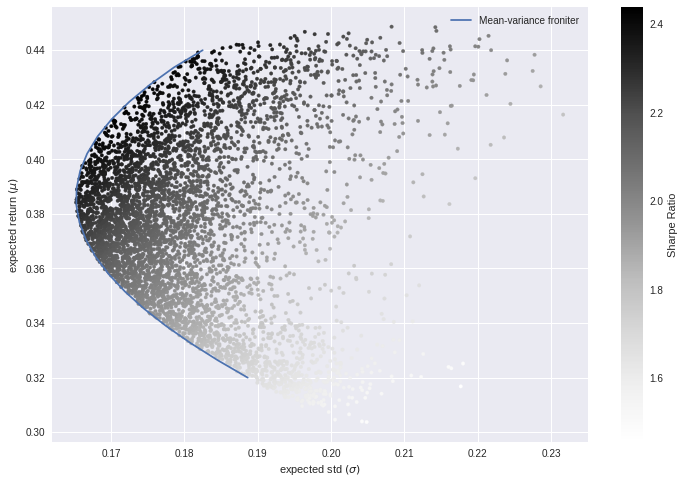

In [33]:
sr = np.array(port_rets) / np.array(port_std)

plt.style.use('seaborn')
plt.figure(figsize = (12, 8))
plt.scatter(port_std, port_rets, 
            c = np.array(port_rets) / np.array(port_std), marker = '.')
plt.plot(tvols, trets, label = 'Mean-variance froniter')
plt.legend()

plt.grid(True)
plt.ylabel('expected return $(μ)$')
plt.xlabel('expected std $(σ)$')
plt.colorbar(label = 'Sharpe Ratio')
'''
Mean-variance frontier는 이 점들의 표면을 이어놓은 점들 (이라고 따로 기술하거나 직접 plot로 그려줘야 함)
'''

2. Risk-free rate이 0.02 일때, 무위험자산까지 포함한 mean-variance frontier를 도출하고 최적 포트폴리오의 annualized sharpe-ratio를 구하시오 (1년을 252일로 계산).

In [34]:
# 1. N개의 위험 자산들 각각의 가중치 계산
# 2. 도출해낸 가중치들을 바탕으로 무위험자산을 포함한 포트폴리오 구성
# 3. 무위험자산과 포트폴리오간의 자산 배분 비율 계산

import scipy.optimize as opt

#5개의 위험자산들을 조합하여 Sharpe Ratio가 극대화되는 지점을 찾는 함수
def min_func_sharpe(weight, rf = 0.02) :
    return -statistics(weight, rf)[2]
    #[2] : Sharpe Ratio, -를 붙이는건 극대화 지점을 찾기 위해

cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1},
        {'type' : 'eq', 'fun' : lambda x : x[0] + x[1] - 0.6})
#제약식 1 : 모든 가중치들의 합은 1 / 제약식 2 : np.dot(weight, ret.mean()) -  pret

bnds = tuple([(0, 0.6) for x in range(noa-2)] + [(0, 0.4) for x in range(noa-3)])
#범위 : 자산 1 0.6, 자산 2~5 : 0 ~ 0.4

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)

# scipy.optimize.minimize(fun, x0, args=(), method=None, bounds=None, constraints=())
# noa * [1. / noa, ] : x0 (초기 실행값)
#-> [1. / noa, ] : [1 / noa] : 리스트, [1. / noa] * noa -> noa개 만큼의 1/noa 설정
opts['x'].round(3)

array([0.531, 0.069, 0.   , 0.21 , 0.19 ])

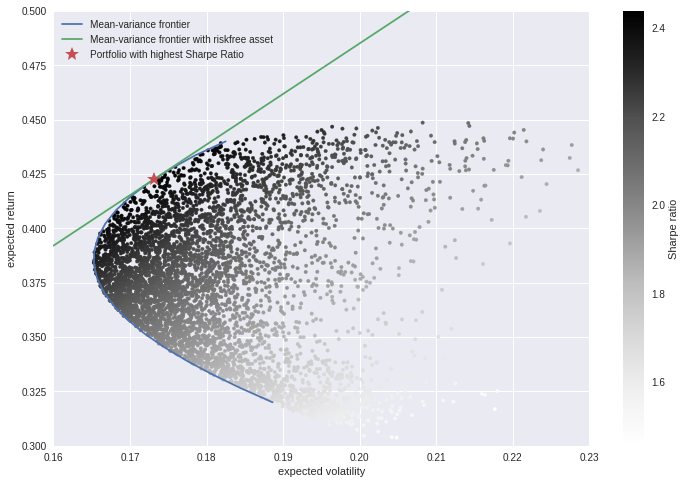

In [35]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
# slope = Sharpe Ratio
# 최적화된 가중치 입력 : statistics(opts['x'])
# 개별자산 [0] - rf / 개별자산

var_list = [x * slope + rf for x in np.linspace(0.16, 0.23, 2500)]
# mu = slope * x + r_f (x : sigma of portfolio, 0.16 ~ 0.24)
# linspace의 범위 : 1번에서 나온 plot의 std의 범위 0.16 ~ 0.24 (샘플 개수는 자유)
# 이는 x축에 대해서도 동일하게 적용해준다 (y에서 설정한 샘플개수와 동일하게 설정한다)

x = np.linspace(0.16, 0.23, 2500)
y = var_list

plt.figure(figsize=(12, 8))

# Mean-variance frontier for only risky assets
plt.plot(tvols, trets, label = 'Mean-variance frontier')

# Random Portfolio 산포도 그리기
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')

# CML : random portfolio which includes risk-free asset composition
# set x = (0.16, 0.24), y : mu = slope * x + r_f
plt.plot(x, y, label = 'Mean-variance frontier with riskfree asset')

# Tangency Portfolio
# random portfolio only with risky assets with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.xlim((0.16, 0.23))
plt.ylim((0.3, 0.5))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [41]:
print("expected return : ", statistics(opts['x'])[0].round(3))
print("expected volatility : ", statistics(opts['x'])[1].round(3))
print("sharpe ratio : ", slope.round(3))

expected return :  0.423
expected volatility :  0.173
sharpe ratio :  2.325
